In [14]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import sys

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, recall_score, make_scorer

from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.width', 1000)

In [2]:
sys.path.append('C:\\Users\\doniz\\Documents\\ChurnAnalysis-Telco\\src')

from visualizacao_churn import plot_freq_customer
from visualizacao_churn import plot_seg_churn_customer
from visualizacao_churn import plot_descr_customer

In [3]:
file_path = 'C:\\Users\\doniz\\Documents\\ChurnAnalysis-Telco\\data\\WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(file_path)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Usando errors='coerce' para converter valores não-numéricos em NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [5]:
# Dividindo os dados em features e target
X = df.drop('Churn', axis=1)  # Supondo que 'Churn' é a coluna alvo
y = df['Churn']

In [6]:
# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

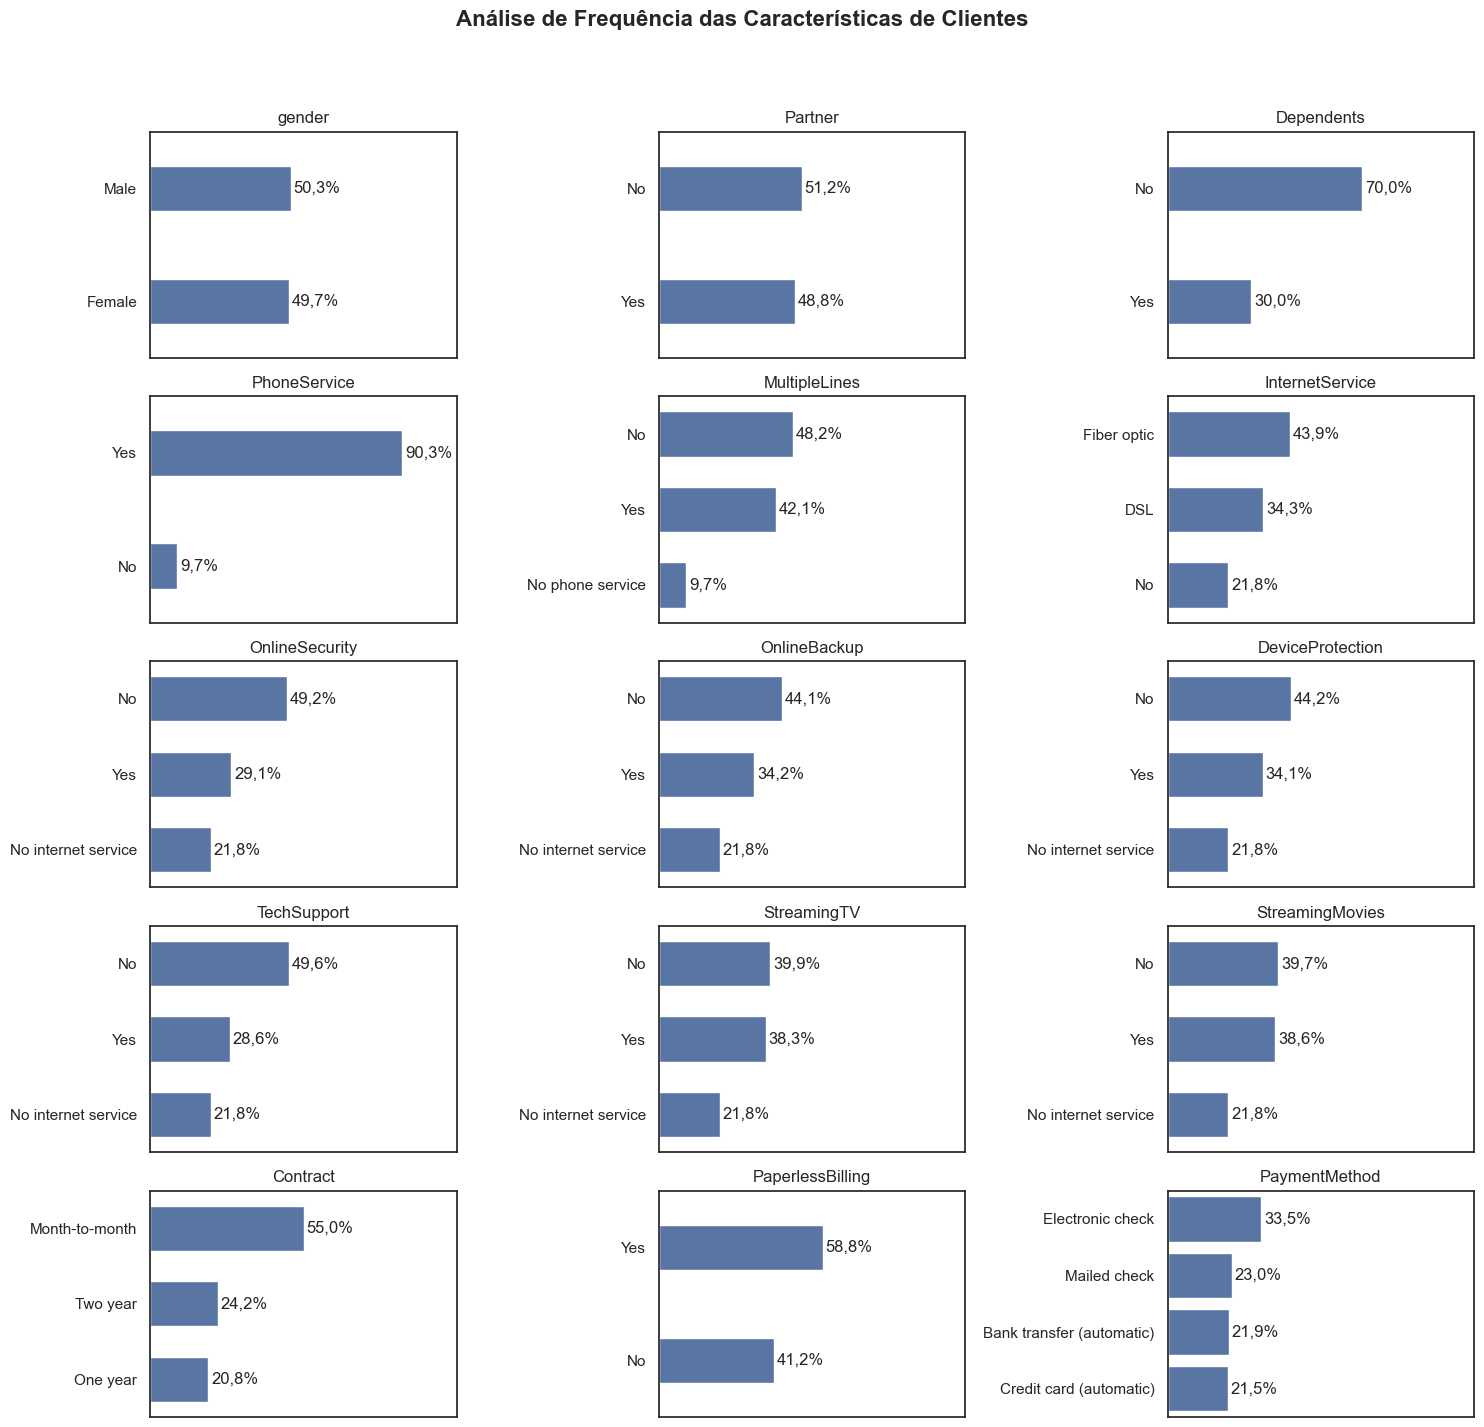

In [58]:
plot_freq_customer(X_train,3)

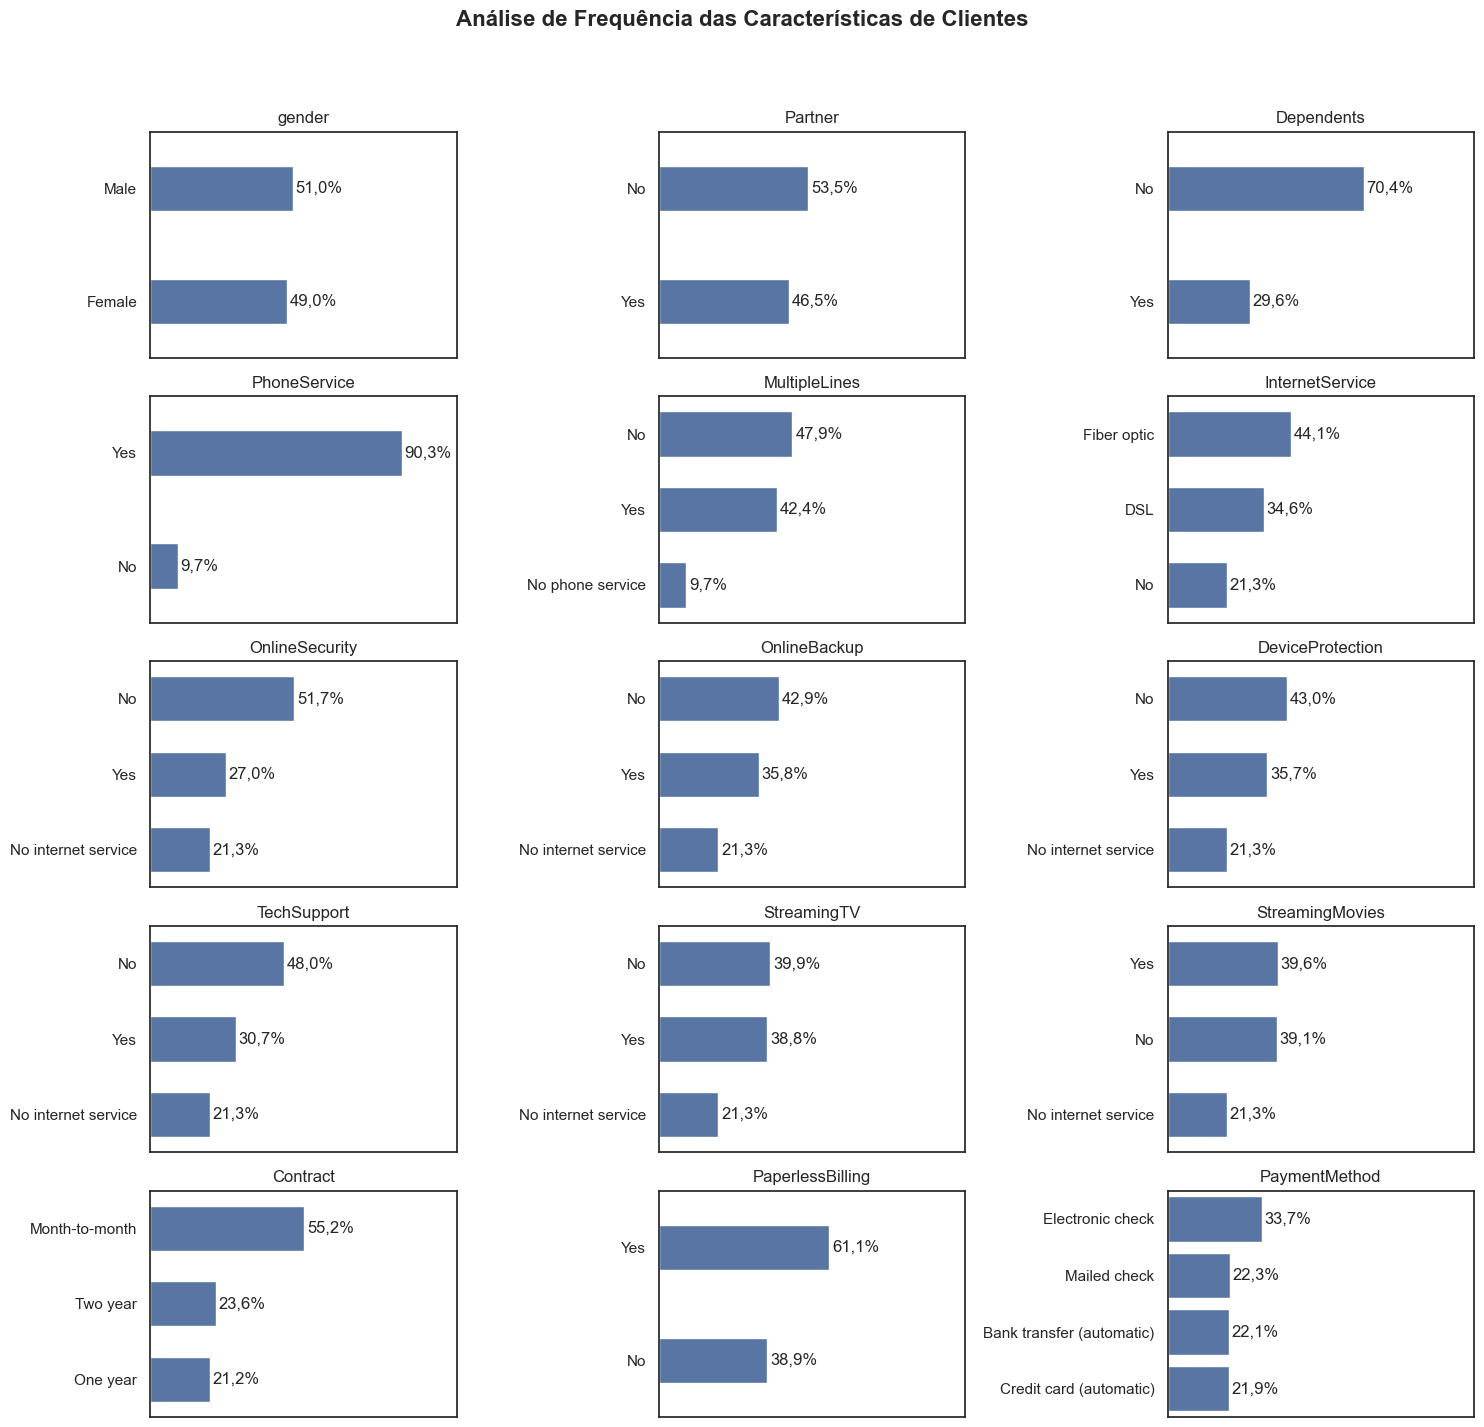

In [60]:
plot_freq_customer(X_test,3)

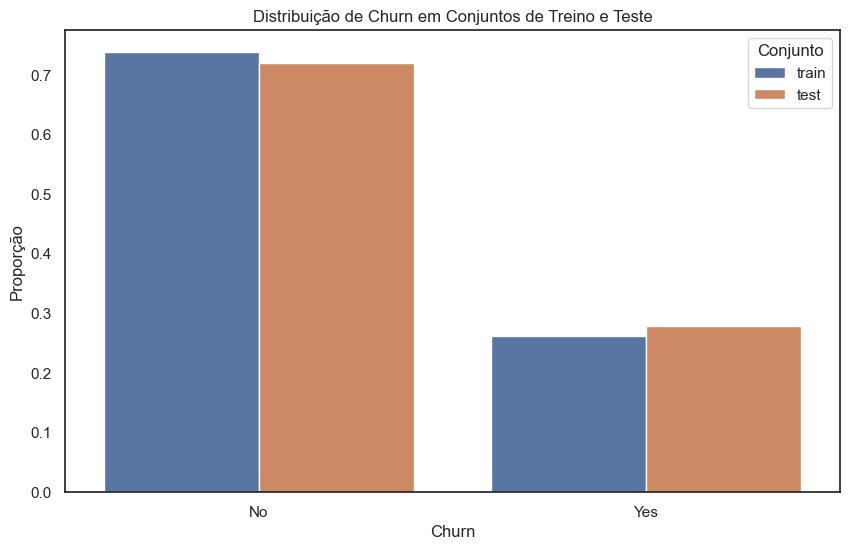

In [46]:
# Calculando as proporções de churn para o conjunto de treinamento e de teste
train_churn_prop = y_train.value_counts(normalize=True)
test_churn_prop = y_test.value_counts(normalize=True)

# Criando um DataFrame para visualização
prop_data = pd.DataFrame({'train': train_churn_prop, 'test': test_churn_prop})
prop_data.reset_index(inplace=True)
prop_data.rename(columns={'index': 'Churn'}, inplace=True)

# Criando o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Churn', y='value', hue='variable', data=pd.melt(prop_data, id_vars='Churn'))
plt.title('Distribuição de Churn em Conjuntos de Treino e Teste')
plt.ylabel('Proporção')
plt.xlabel('Churn')
plt.legend(title='Conjunto')
plt.show()

In [7]:
y_train.reset_index(drop=True, inplace=True)

In [8]:
# Codificar os rótulos
encoder_y = LabelEncoder()
y_train_encoded = encoder_y.fit_transform(y_train)

In [9]:
X_train.reset_index(drop=True, inplace=True)

In [10]:
# Criar o encoder, opcionalmente usando drop='first' para evitar multicolinearidade
encoder = OneHotEncoder(drop='first')  # remove uma coluna para evitar multicolinearidade

In [11]:
# Treinar o encoder no conjunto de teste (idealmente deveria ser no conjunto de treino)
category_column = X_train.dtypes[(X_train.dtypes == 'object')&(~X_train.dtypes.index.isin(['customerID','gender','PhoneService']))].index
encoder.fit(X_train[category_column])

OneHotEncoder(drop='first')

In [12]:
# Transformar a coluna categórica
encoded_features = encoder.transform(X_train[category_column]).toarray()
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

In [13]:
# Concatenar com o DataFrame original (removendo a coluna categórica original)
X_train_encoded = pd.concat([X_train.drop(category_column, axis=1), encoded_features_df], axis=1)

In [87]:
X_train_encoded.head()

,customerID,gender,SeniorCitizen,tenure,PhoneService,MonthlyCharges,TotalCharges,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,6457-GIRWB,Male,0,1,Yes,69.35,69.35,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
1,5115-GZDEL,Male,0,72,No,67.20,4671.70,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00
2,3398-ZOUAA,Male,1,21,Yes,69.10,1474.75,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
3,7011-CVEUC,Male,0,25,Yes,95.70,2338.35,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
4,3836-FZSDJ,Male,1,71,Yes,24.85,1901.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [88]:
# Configurando os modelos
models = {
    'RandomForest': RandomForestClassifier(random_state=123),
    'XGBoost': XGBClassifier(use_label_encoder=False, random_state=123),
    'LightGBM': LGBMClassifier(verbose=-1, random_state=123)
}

In [91]:
# Avaliação usando validação cruzada
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_encoded.drop(['customerID','gender','PhoneService'],axis=1), y_train_encoded, cv=10, scoring='accuracy')
    results[name] = scores
    print(f'{name}: {np.mean(scores):.3f} (+/- {np.std(scores):.3f})')

RandomForest: 0.800 (+/- 0.011)
XGBoost: 0.786 (+/- 0.013)
LightGBM: 0.798 (+/- 0.015)


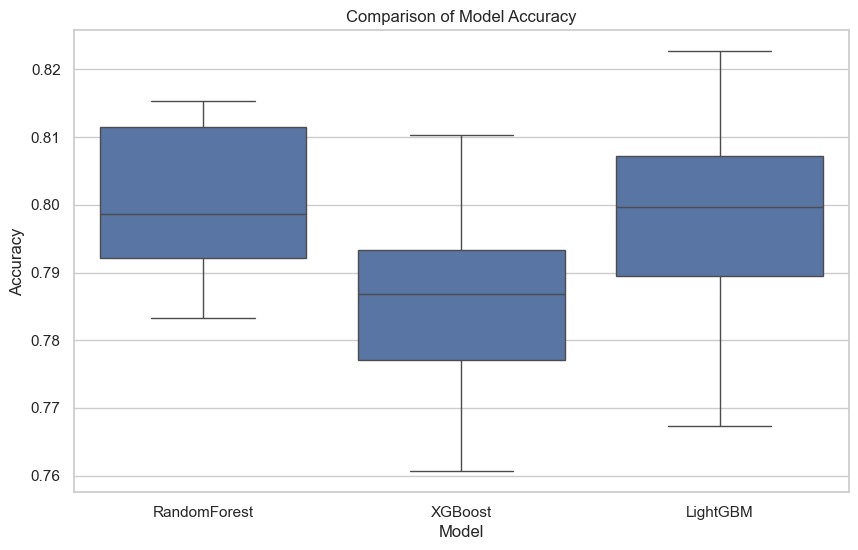

In [92]:

# Convertendo o dicionário em DataFrame para visualização
data = []
for model_name, scores in results.items():
    for score in scores:
        data.append({'Model': model_name, 'Accuracy': score})
df_scores = pd.DataFrame(data)

# Configurando o estilo do gráfico
sns.set(style="whitegrid")

# Criando o boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Model', y='Accuracy', data=df_scores)

# Adicionando títulos e rótulos
ax.set_title('Comparison of Model Accuracy')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')

# Mostrando o gráfico
plt.show()


In [97]:
# Dividindo os dados em conjuntos de treino e teste
X_train2, X_valida, y_train2, y_valida = train_test_split(X_train_encoded.drop(['customerID','gender','PhoneService'],axis=1), y_train_encoded, test_size=0.20, random_state=123)

In [98]:
# Treinar cada modelo
for name, model in models.items():
    model.fit(X_train2, y_train2)

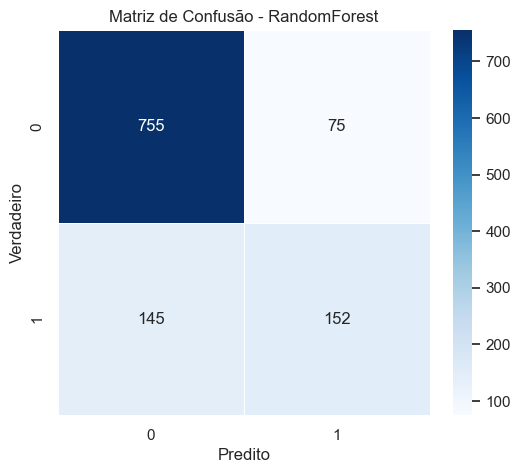

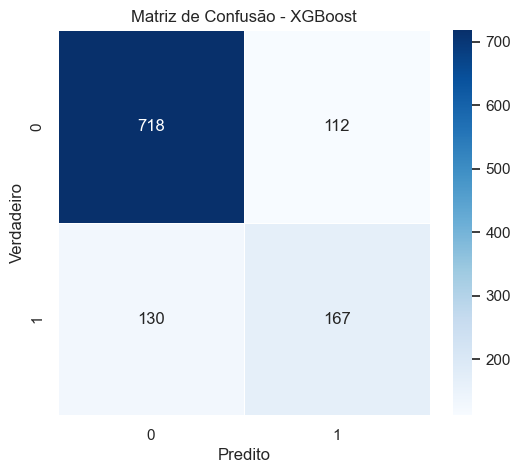

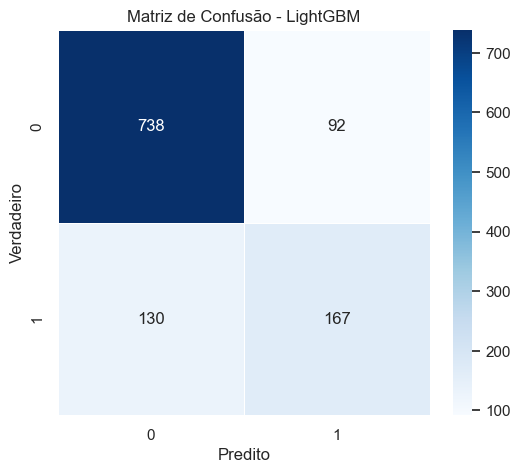

In [99]:
# Configurando o estilo do gráfico
sns.set(style="white")

# Criar matrizes de confusão para cada modelo
for name, model in models.items():
    y_pred = model.predict(X_valida)
    cm = confusion_matrix(y_valida, y_pred)
    
    # Plotando a matriz de confusão
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues")
    plt.title(f'Matriz de Confusão - {name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()


In [101]:
# Avaliação usando validação cruzada
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_encoded.drop(['customerID','gender','PhoneService'],axis=1), y_train_encoded, cv=10, scoring='recall')
    results[name] = scores
    print(f'{name}: {scores.mean():.3f} (+/- {scores.std():.3f})')

RandomForest: 0.494 (+/- 0.031)
XGBoost: 0.503 (+/- 0.039)
LightGBM: 0.512 (+/- 0.035)


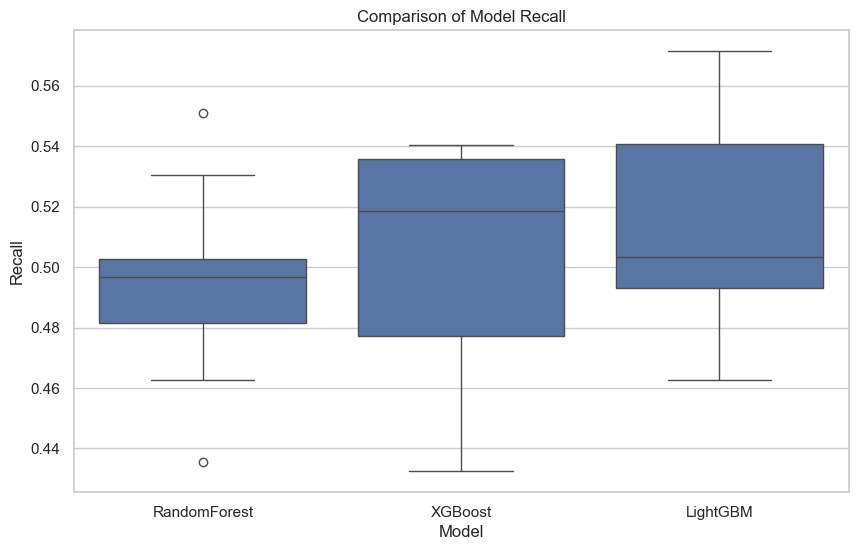

In [104]:

# Convertendo o dicionário em DataFrame para visualização
data = []
for model_name, scores in results.items():
    for score in scores:
        data.append({'Model': model_name, 'Recall': score})
df_scores = pd.DataFrame(data)

# Configurando o estilo do gráfico
sns.set(style="whitegrid")

# Criando o boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Model', y='Recall', data=df_scores)

# Adicionando títulos e rótulos
ax.set_title('Comparison of Model Recall')
ax.set_xlabel('Model')
ax.set_ylabel('Recall')

# Mostrando o gráfico
plt.show()


In [26]:
def apply_threshold(probabilities, threshold=0.5):
    return (probabilities >= threshold).astype(int)


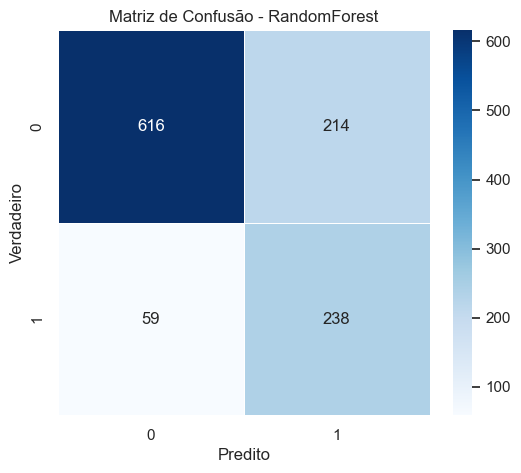

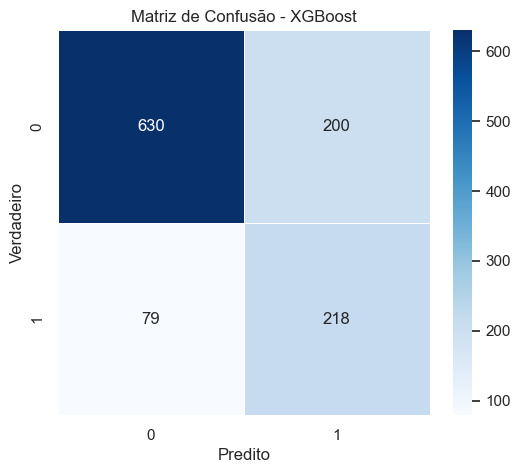

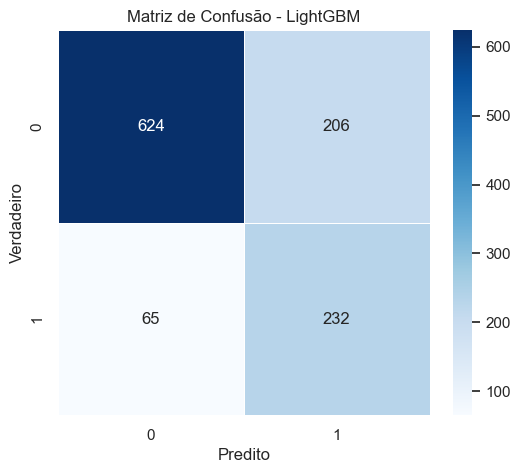

In [110]:
# Definindo um novo threshold
new_threshold = 0.265

# Configurando o estilo do gráfico
sns.set(style="white")

# Criar matrizes de confusão para cada modelo
for name, model in models.items():
    y_pred = apply_threshold(model.predict_proba(X_valida)[:, 1], threshold=new_threshold)
    cm = confusion_matrix(y_valida, y_pred)
    
    # Plotando a matriz de confusão
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues")
    plt.title(f'Matriz de Confusão - {name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()


In [15]:
# Modelo base
model = XGBClassifier(use_label_encoder=False, random_state=123)

In [16]:
# Espaço de parâmetros para a busca aleatória
param_dist = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': np.arange(3, 15),
    'learning_rate': np.logspace(-3, 0, num=10),
    'subsample': np.linspace(0.5, 1.0, num=6),
    'colsample_bytree': np.linspace(0.5, 1.0, num=6),
    'gamma': [0.5, 1, 1.5, 2, 5]
}

In [21]:
# Randomized Search com validação cruzada
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=500,  # Número de iterações de configuração de parâmetros a serem testadas
    scoring='recall',  # ou outra métrica de sua preferência
    cv=7,  # Número de folds na validação cruzada
    verbose=1,
    random_state=123,
    n_jobs=-1  # Utiliza todos os núcleos disponíveis
)


In [22]:
# Executando a busca aleatória
random_search.fit(X_train_encoded.drop(['customerID','gender','PhoneService'],axis=1), y_train_encoded)


Fitting 7 folds for each of 500 candidates, totalling 3500 fits


RandomizedSearchCV(cv=7,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=123, scoring='recall', verbose=1)

In [24]:
# Melhores parâmetros encontrados
print("Melhores parâmetros:", random_search.best_params_)

# Melhor score alcançado
print("Melhor score:", random_search.best_score_)

# Melhor modelo
best_model = random_search.best_estimator_



Melhores parâmetros: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 13, 'learning_rate': 1.0, 'gamma': 5, 'colsample_bytree': 0.7}
Melhor score: 0.5491827062578586


In [25]:
y_prob = best_model.predict_proba(X_train_encoded.drop(['customerID','gender','PhoneService'],axis=1))[:, 1]

In [27]:
new_threshold = 0.265
y_pred = apply_threshold(y_prob, threshold=new_threshold)

In [28]:
def calculate_score_with_threshold(probabilities, threshold, true_labels):
    predictions = (probabilities >= threshold).astype(int)
    score = recall_score(true_labels, predictions)  # Ou qualquer outra métrica de interesse
    return score

In [30]:
thresholds = np.linspace(0.1, 0.9, 9)  # Thresholds de 0.1 a 0.9
scores = []

for thresh in thresholds:
    score = calculate_score_with_threshold(y_prob, thresh, y_train_encoded)
    scores.append(score)
    print(f'Threshold: {thresh:.1f}, Score: {score:.3f}')

Threshold: 0.1, Score: 0.950
Threshold: 0.2, Score: 0.860
Threshold: 0.3, Score: 0.753
Threshold: 0.4, Score: 0.656
Threshold: 0.5, Score: 0.569
Threshold: 0.6, Score: 0.458
Threshold: 0.7, Score: 0.333
Threshold: 0.8, Score: 0.195
Threshold: 0.9, Score: 0.035


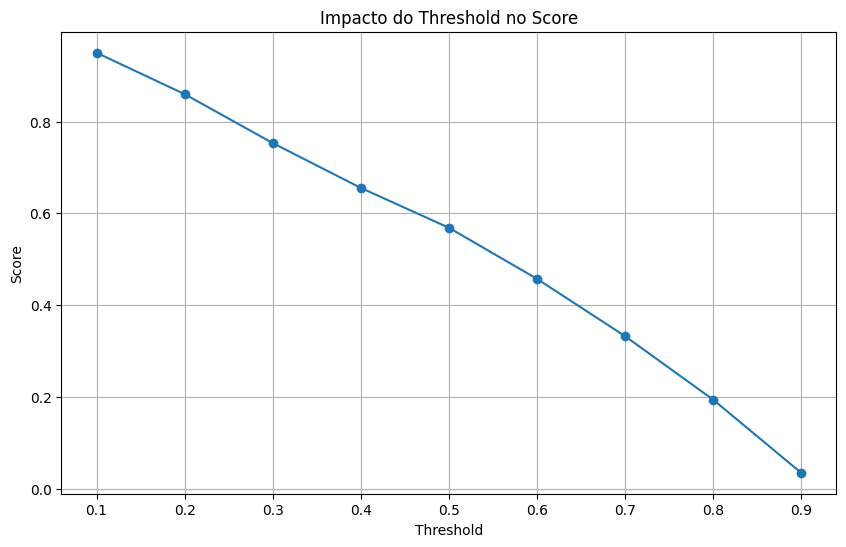

In [31]:

plt.figure(figsize=(10, 6))
plt.plot(thresholds, scores, marker='o')
plt.title('Impacto do Threshold no Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.show()
